In [5]:
%matplotlib notebook
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

># Analysis Code for the Edge Illumination Method:   

En las siguientes líneas de código se encuentran los recursos necesarios para leer los archivos .raw y así obtener los archivos .txt. En la segunda parte de este código se encuentra el análisis estadístico asociado a las imágenes anteriormente interpretadas, con la inclusión de la normalización mediante un _Flat Field_ y el posterior análisis de la recuperación de fase.

> **Código para lectura de los Raw:**

Esta primera sección abarca los códigos empleados para la lectura de los archivos .raw. Cada archivo se asume ha sido almacenado con el prefijo "Frame", para simplificar los procesos.

In [6]:
Pixels = 256 # Cantidad de Píxeles del Detector.
N_Raws = 4 # Cantidad de imágenes a analizar (ingresar un valor >= 2).
N_Dopple = 2 # El archivo .raw genera dos imágenes, este número indica eso para promediarlas.
path_raw = "C:\\Users\\Thomas\\XPCi_Project_Code\\Image_Analysis\\RAWs\\" # Directorio donde están los Raw.
path_txt = "C:\\Users\\Thomas\\XPCi_Project_Code\\Image_Analysis\\Txts\\" # Directorio donde se ponen los Txt.

In [7]:
Step = "27.5" # Dato de geometry_config.in
Name_Used = "1CM"

In [10]:
"""
/// Generación de las imágenes a partir de los archivos .raw.
"""

def Matrix_Creator(Raw, Pixels):
    """
    Esta función genera una lista con un par de matrices que representan las dos imágenes que surgen al
    analizar el archivo .raw.
    """
    image_pair = []
    for k in range(0, len(Raw), Pixels*Pixels):
        blank = np.zeros((Pixels, Pixels))
        for i in range(Pixels):
            for j in range(Pixels):
                blank[i, j] = Raw[j + Pixels*i + k]
        image_pair.append(blank)
    return image_pair

def Data_Import(name, Pixels, NRaw):
    """
    Esta función se encarga de tomar la información de la ubicación de la carpeta con los archivos .raw
    y crear las matrices de números asociadas a cada una de las tomas de datos.
    
    Inputs:
        name: Directorio de la carpeta donde están los .raw.
        Pixels: Cantidad de píxeles de la matriz del detector.
        NRaw: Cantidad de imágenes .raw a analizar.
    
    Output:
        data: Lista con los pares de matrices de intensidad de cada .raw.
    """
    data = []
    for i in range(1, NRaw + 1):
        Raw = np.fromfile(name + "Frame{}.raw".format(i), dtype='float32')
        matrix = Matrix_Creator(Raw, Pixels)
        data.append(matrix)
    
    try:
        Raw = np.fromfile(name + "Frame_FF.raw", dtype='float32')
        matrix = Matrix_Creator(Raw, Pixels)
        data.append(matrix)
    except UnboundLocalError:
        None
        
    return data

def Image_Generator(data, N_images, N_Dopple):
    """
    Esta función genera una lista con las matrices asociadas a cada imágen tomada. Se hace promediando
    las dos matrices de cada .raw para tener la intensidad media.
    
    Inputs:
        data: Lista con cada par de matrices asociado a los .raw que se analizaron.
        N_images: Cantidad de imágenes que se generarán.
        N_Dopple: Cantidad de imágenes por archivo .raw (no sabemos si varía).
    
    Output:
        images: Lista con las matrices asociadas a cada imagen analizada.
    """
    images = [] 
    for i in range(0, N_images):
        mean = (data[i][0] + data[i][1])/2
        images.append(mean)
    if len(data) > N_images:
        mean = (data[N_images][0] + data[N_images][1])/2
        images.append(mean)
    return images

"""
/// Creación de los histogramas de comparación entre píxeles pares e impares.
"""

def Intensity_Mean(image, Pixels):
    intensity = np.zeros(Pixels)
    for i in range(0, Pixels):
        intensity += image[i, 0:Pixels]
    mean = intensity/np.max(intensity)
    return mean


def Aver(name,X1,X2,Step):
    P=np.copy(name)
    for i in range(len(P)):
        P[i,X1:X2]=(1/2)*(P[i,X1-Step:X2-Step]+P[i,X1+Step:X2+Step])
    return P

In [11]:
brute_material = Data_Import(path_raw, Pixels, N_Raws)
images = Image_Generator(brute_material, N_Raws, N_Dopple)
for i in range(1, N_Raws + 1):
    try:
        np.savetxt(path_txt + "Frame{}.txt".format(i), images[i - 1])
    except IndexError:
        np.savetxt(path_txt + "{}.txt".format(Name_Used), images[0])
        break
        
if len(brute_material) > N_Raws:
    np.savetxt(path_txt + "FrameFF.txt", images[N_Raws])

> **Visualización previa:**

A continuación se puede observar el mapa de intensidades asociado a la imagen $k$-ésima de la lista images. Si el conjunto de imágenes incluye el Flat Field, se debe de colocar el valor de $k$ igual a $-1$ (último item de la lista). El mapa mostrado **no está normalizado**.

<IPython.core.display.Javascript object>


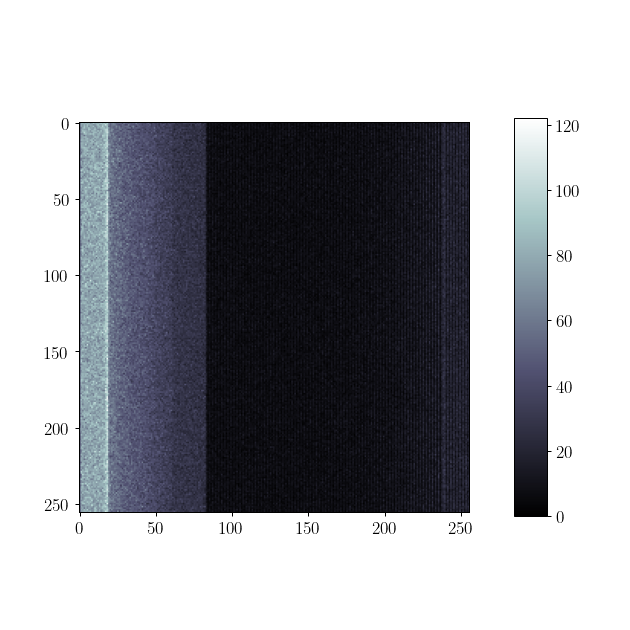

In [12]:
k = 0
fig, ax = plt.subplots(figsize=(7, 7))
map_ = ax.imshow(images[k], cmap = "bone")
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)

En este apartado se logra apreciar la curva asociada a las intensidades de cada columna de píxeles, estando estos valores normalizados.

<IPython.core.display.Javascript object>


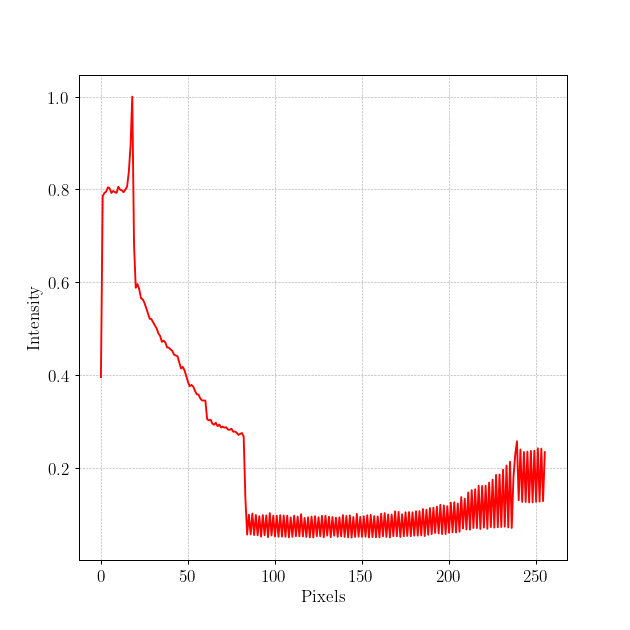

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
intensities = Intensity_Mean(images[k], Pixels)
ax.plot(intensities, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 14)
ax.set_ylabel("Intensity", fontsize = 14)
ax.grid(linestyle = '--', linewidth = 0.5)

> **Histograma de Intensidades:**

Este histograma permite conocer la distribución de intensidades entre los píxeles pares e impares. Para poder determinar qué tan óptimo es el step seleccionado, ambos histogramas deben estár lo más superpuestos posible.

<IPython.core.display.Javascript object>


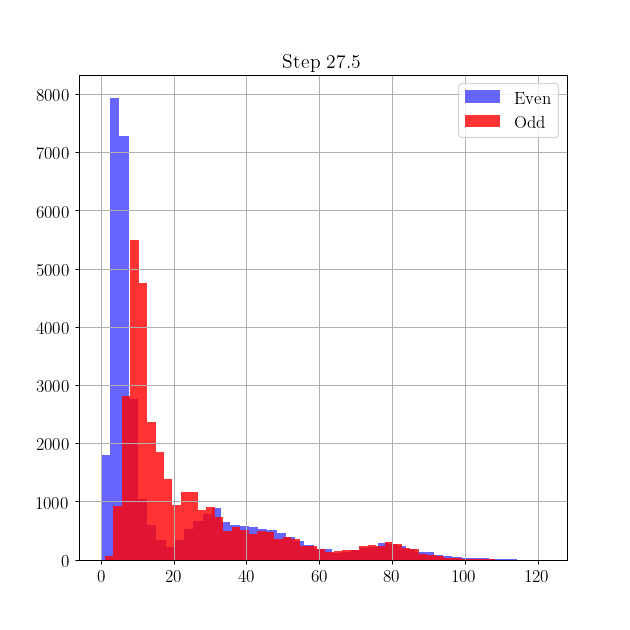

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(True)

even_pixels = images[k][:,::2]
odd_pixels = images[k][:,1::2]
even_ = np.ravel(even_pixels)
odd_ = np.ravel(odd_pixels)

bin_size = 48
GNMe =ax.hist(even_, bins = bin_size, color="blue", label="Even", alpha=0.6)
GNMo =ax.hist(odd_, bins = bin_size, color="red", label="Odd", alpha=0.8)
ax.set_title("Step {}".format(Step), fontsize=16)
ax.legend()

> **Normalización:**

Una vez leídos y guardados los archivos .raw, se reescriben de forma tal que los valores se encuentren normalizados en función del Flat Field recolectado.

In [34]:
for i in range(1, N_Raws + 1):
    try:
        Frame = np.loadtxt(path_txt + "Frame{}.txt".format(i))  # Carga las imágenes tomadas.
        FrameFF = np.loadtxt(path_txt + "FrameFF.txt")  # Carga la imagen del Flat Field.
    except Exception as e:
        print(f"Error al cargar los archivos: {e}")
        sys.exit()

    # Realizar la división evitando división por cero
    N_Frame = np.divide(Frame, FrameFF, out = np.zeros_like(Frame), where = FrameFF != 0)
    np.savetxt(path_txt + "Norm\\Frame_{}.txt".format(i), N_Frame, fmt = "%.6f")  

> **Código para la suma de las imágenes:**

In [35]:
z_FS = 0.6 # Distancia Fuente - Objeto
z_SD = 1.2 # Distancia Objeto - Detector
z_FD = z_FS + z_SD # Distancia Fuente - Detector
M = z_FD/z_FS # Magnificación

# Todos estos parámetros están aún por ser determinados en su significado.
a =  31.6*(10**(-6)) # Tamaño de apertura de la máscara.

In [36]:
txt_images = []
for i in range(1, N_Raws + 1):
    image = np.genfromtxt(path_txt + "Frame{}.txt".format(i))
    txt_images.append(image)

In [37]:
Odd_Maps = []
Even_Maps =[]
Absor_Maps = []
Phase_Maps = []

for i in range(0, N_Raws): 
    odd = txt_images[i][:,1::2]
    even = txt_images[i][:,::2]
    absor = (txt_images[i][:,::2] + txt_images[i][:,1::2])/2
    phase =((M*a)/2)*((txt_images[i][:,1::2] - txt_images[i][:,::2])/(txt_images[i][:,1::2] + txt_images[i][:,::2]))
    
    Odd_Maps.append(odd)
    Even_Maps.append(even)
    Absor_Maps.append(absor)
    Phase_Maps.append(phase)

In [45]:
Odd_Dith = np.zeros((Pixels, int(N_Raws*Pixels/2)))
Even_Dith = np.zeros((Pixels, int(N_Raws*Pixels/2)))
Absor_Dith = np.zeros((Pixels, int(N_Raws*Pixels/2)))
Phase_Dith = np.zeros((Pixels, int(N_Raws*Pixels/2)))

for i in range(0, N_Raws):
    for j in range(0, int(Pixels/2)):
        Odd_Dith[:,N_Raws*j + i:N_Raws*j + i + 1] = Odd_Maps[N_Raws - 1 - i][:,j:j + 1]
        Even_Dith[:,N_Raws*j + i:N_Raws*j + i + 1] = Even_Maps[N_Raws - 1 - i][:,j:j + 1]
        Absor_Dith[:,N_Raws*j + i:N_Raws*j + i + 1] = Absor_Maps[N_Raws - 1 - i][:,j:j + 1]
        Phase_Dith[:,N_Raws*j + i:N_Raws*j + i + 1] = Phase_Maps[N_Raws - 1 - i][:,j:j + 1]

Factor = Odd_Dith.shape[1]/Odd_Dith.shape[0]

Odd = zoom(Odd_Dith, (Factor, 1))
Even = zoom(Even_Dith, (Factor, 1))
Absor= zoom(Absor_Dith, (Factor, 1))
Phase = zoom(Phase_Dith, (Factor, 1))
Total = (Even + Odd)/np.max(Even + Odd)

I_Absor = Intensity_Mean(Absor, Absor.shape[0])
I_Phase = Intensity_Mean(Phase, Phase.shape[0])
I_Total = Intensity_Mean(Total, Total.shape[0])

<IPython.core.display.Javascript object>


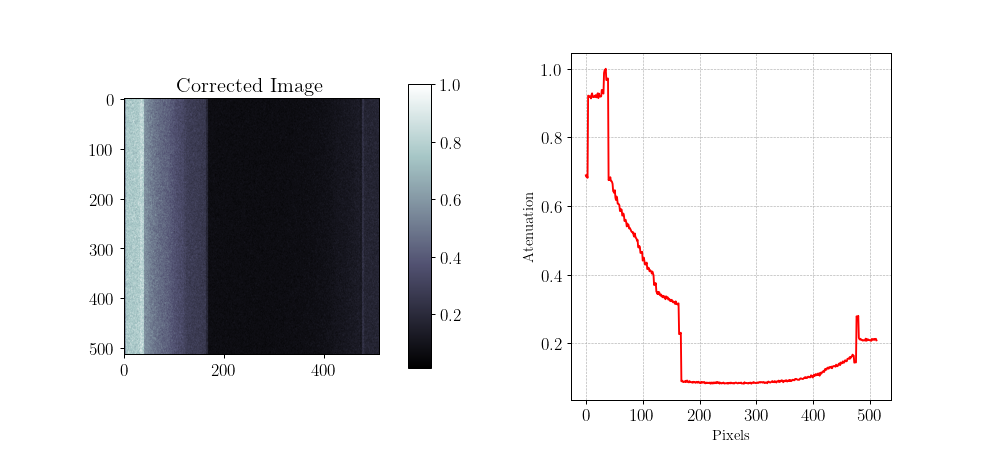

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.4)

ax[0].set_title("Corrected Image")
im = ax[0].imshow(Total, cmap="bone")
fig.colorbar(im, ax = ax[0], location = 'right', anchor = (0.5, 0.5), shrink = 0.82, aspect = 12)

ax[1].plot(I_Total, '-', color = "red")
ax[1].set_xlabel("Pixels", fontsize = 12)
ax[1].set_ylabel("Atenuation", fontsize = 12)
ax[1].grid(linestyle = '--', linewidth = 0.5)

<IPython.core.display.Javascript object>


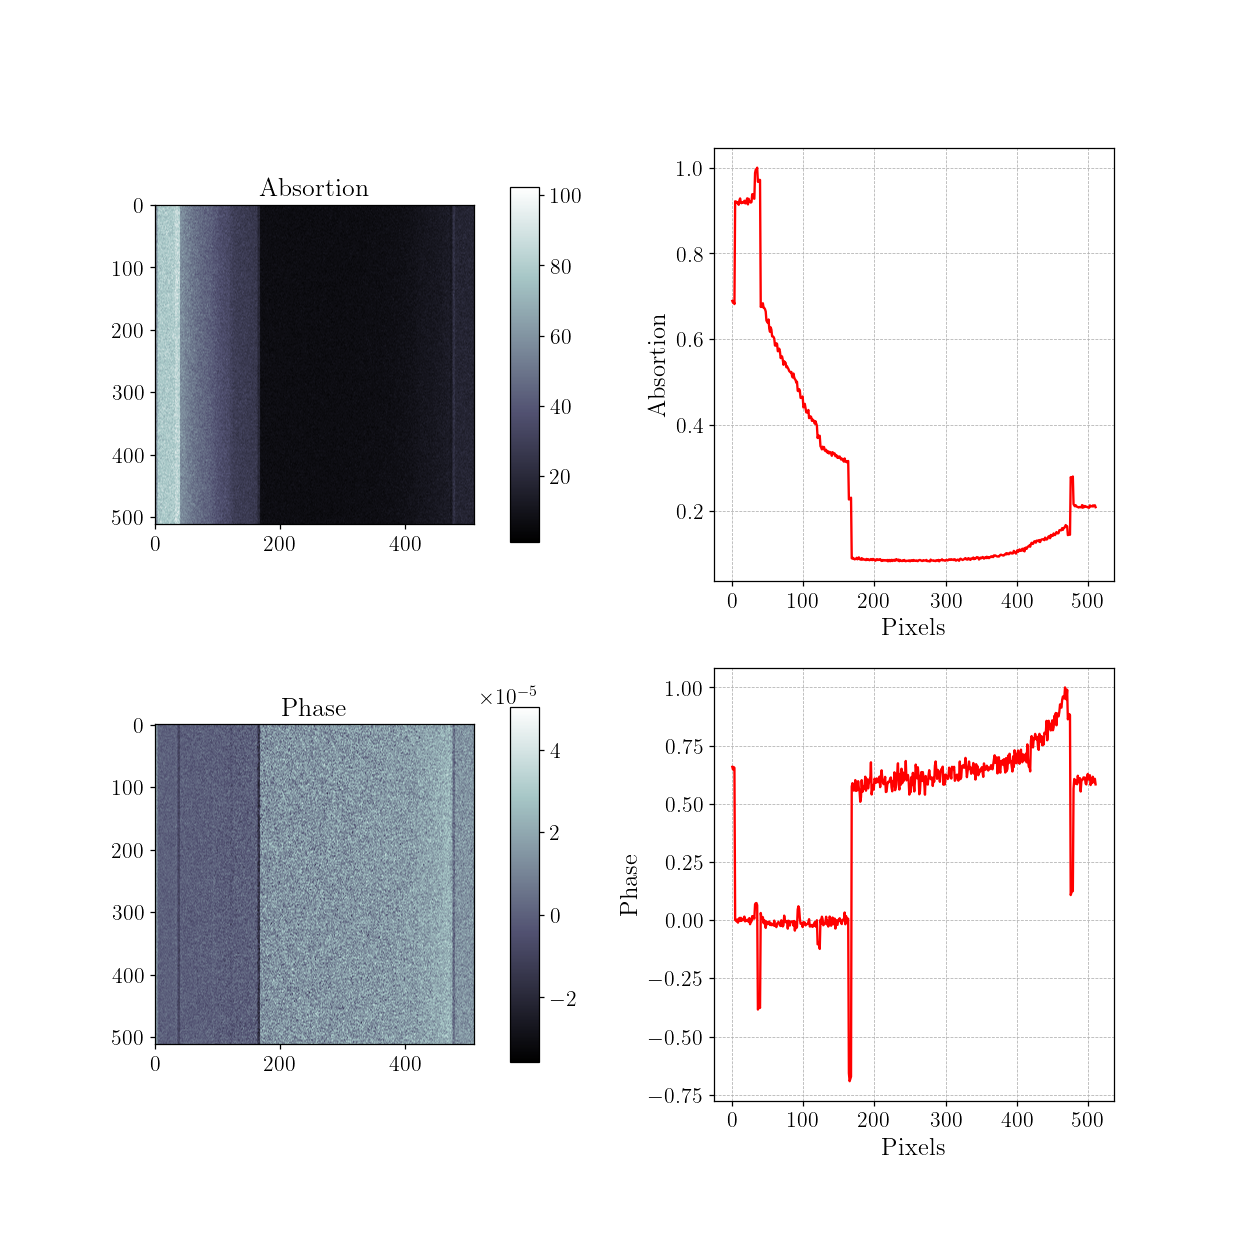

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(11, 11))
plt.subplots_adjust(wspace = 0.4)

ax[0, 0].set_title("Absortion")
im = ax[0, 0].imshow(Absor, cmap="bone")
fig.colorbar(im, ax = ax[0, 0], location = 'right', anchor=(0.5, 0.5), shrink = 0.82, aspect = 12)

ax[1, 0].set_title("Phase")
im_ = ax[1, 0].imshow(Phase, cmap="bone")
fig.colorbar(im_, ax = ax[1, 0], location = 'right', anchor=(0.5, 0.5), shrink = 0.82, aspect = 12)

ax[0, 1].plot(I_Absor, '-', color = "red")
ax[0, 1].set_xlabel("Pixels", fontsize = 16)
ax[0, 1].set_ylabel("Absortion", fontsize = 16)
ax[0, 1].grid(linestyle = '--', linewidth = 0.5)

ax[1, 1].plot(I_Phase, '-', color = "red")
ax[1, 1].set_xlabel("Pixels", fontsize = 16)
ax[1, 1].set_ylabel("Phase", fontsize = 16)
ax[1, 1].grid(linestyle = '--', linewidth = 0.5)